# Importing Masterliste Werke+Aufnahmen

The sheet "machine readable" contains the fixed data including manually added folder and file names for csv data files (tappings)

## Preparation
Download sheet "machine readable" as csv.


In [1]:
%matplotlib inline

# Adding data from notebooks

## Audio conversion

In [3]:
from pydub import AudioSegment

data_dir = "/home/martin/Workspace/musicData/data/recordings/BRUCKNER_Sym9-3_-_ABBADO_WPh_1996_LIVE_DG_[471 032-2]"
file_name = data_dir + "/" + "03_BRUCKNER_Sym9-3_-_ABBADO_WPh_1996_LIVE_DG_[471 032-2].flac"

song = AudioSegment.from_file(file_name, "flac")
song.export(file_name + ".wav", format="wav")



<_io.BufferedRandom name='/home/martin/Workspace/musicData/data/recordings/BRUCKNER_Sym9-3_-_ABBADO_WPh_1996_LIVE_DG_[471 032-2]/03_BRUCKNER_Sym9-3_-_ABBADO_WPh_1996_LIVE_DG_[471 032-2].flac.wav'>

## OMA API

<Response [200]>


## Using the OMA API to upload the data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import os
from pydub import AudioSegment

from omapy.api import oma
import librosa


url = "http://localhost:8080/"
login = oma.login(url, "oma", "=PSe?sZ-ymp6mE>2", False)
print(login)

data_list = "data/Masterliste Werke+Aufnahmen - machine readable.csv"
data_dir = "/home/martin/Workspace/musicData/data/"
df = pd.read_csv(data_list)

df.head()



filtered_data = df[df['tapping_files'].notnull()]
    
for index, row in filtered_data.iterrows():
    
    tapping_file_list = row['tapping_files'].split(",")
    
    # parse row
    composer = row["Komponist"]
    work = row["Werkname"]
    part_number = row["Satz_Nr"]
    conductor = row["Dirigent"]
    orchestra = row["Orchester"]
    year = row["Aufnahmejahr"]
    
    # print(composer, work, part_number, conductor, orchestra, year)
    
    c = {"name": composer}
    c = oma.composer_add(c)
    print(c)

    composition = {"title": work, "composer": c["id"]}
    composition = oma.composition_add(composition)
    print(composition)
    
    # interpretation
    interpretation = {"title":  conductor + ", " + orchestra + ", " + str(year)}
    interpretation = oma.interpretation_add(interpretation)
    print(interpretation)
    
    
    # abstract music (work) part of composition
    
    if math.isnan(row["Takt von"]):
        row["Takt von"] = 0.0
    
    if math.isnan(row["Takt bis"]):
        row["Takt bis"] = 0.0
    
    # offset and lengths in OMA instead of start and end. It's equivalent   
    row["Takt bis"] = row["Takt bis"] - row["Takt von"] 
    
    abstract_music_part = {
        "title": "Movement " + str(part_number),
        "movement": part_number,
        "composition": composition["id"],
        "interpretation": interpretation["id"],
        "bar_number_offset": row["Takt von"],
        "number_of_bars": row["Takt bis"]
    }
    
    score_path = "/home/martin/Workspace/musicData/data/scores"
    score_file = score_path + "/" + row["score_file"]
    
    files = {
        "file": (score_file, open(score_file, 'rb'), 'application/pdf', {'Expires': '0'})    
    }
    abstract_music_part = oma.interpretation_add_abstract_music_part(abstract_music_part, files)
    print(abstract_music_part)
    
    
    # recording and audio files
    audio_path = data_dir + "recordings/" +row["recording_folder"]
    audio_file_list = os.listdir(audio_path)
    legit_audio_files = []
    for a in audio_file_list:
        if a.endswith(".flac"): # or .wav or whatever
            legit_audio_files.append(a)
    
    if (len(legit_audio_files) != 1):
        print ("only single audio file supported")
        sys.exit(1)
    
    file_name = legit_audio_files[0]
    audio_file = audio_path + file_name
    wav_file = audio_file + ".wav"
    mp3_file = audio_file + ".64k.mp3"
    
    sound = AudioSegment.from_file(audio_file, "flac")
    # song.export(wav_file, format="wav")
    
    
    if os.path.isfile(mp3_file) == False:
        print("converting")
        sound.export(mp3_file, format="mp3", bitrate="64k")
        
    
    recording = {
        "title": "Recording of " + str(row["Aufnahmejahr"]),
        "interpretation": interpretation["id"],
        "abstract_music_part": abstract_music_part["id"]       
    }
    files = {
        # "file": (wav_file, open(wav_file, 'rb'), 'audio/wav', {'Expires': '0'})
        "file": (mp3_file, open(mp3_file, 'rb'), 'audio/mpeg', {'Expires': '0'})
    
    }
    
    recording = oma.recording_add(recording, files)
    print(recording)
    
    
    # tappings. multiple files possible
    for i in range(0, len(tapping_file_list)):
        # print("\t", tapping_file_list[i])
        # import that tapping file to recording
        cwd = data_dir + row["tapping_folder"]
        tapping_file_name = tapping_file_list[i].rstrip()
        tapping_file_path = cwd + "/" + tapping_file_name
        # print(tapping_file_path)
        if os.path.isfile(tapping_file_path) == False:
            print("File not found")
        # tapping_data = parse_t_csv(cwd + "/" + tapping_file_name)
        # upload tapping data
        session = {
            "recording": recording["id"],
            "tapping_file_name": tapping_file_name
        }
        files = {
            "file": (tapping_file_name, open(tapping_file_path, 'rb'), 'text/csv', {'Expires': '0'})
    
        }
        session = oma.session_add(session, files)
        print(session["id"])
        
    print("")
    print("Done!")
        



<Response [200]>
{'compositions': [{'id': 29330}], 'tenantId': 3, 'name': 'Ludwig van Beethoven', 'id': 29329}
{'tenantId': 3, 'title': 'Symphonie No. 9', 'composer': {'id': 29329}, 'id': 29330}
{'abstractMusicParts': [{'id': 29332}], 'tenantId': 3, 'title': 'Herbert von Karajan, Berliner Philharmoniker, 1957', 'recordings': [{'id': 29333}], 'id': 29331}
{'tenantId': 3, 'numberOfBars': 0.0, 'pdfLocation': 'https://s3.amazonaws.com/open-music-annotations-storage-backend/development/abstractMusicPart/29332/IMSLP516488-PMLP1607-Beethoven_-_Symphony_No.9,_Op.125.pdf', 'interpretation': {'id': 29331}, 'title': 'Movement 1', 'pdfPageChangeAnnotationSession': None, 'barNumberOffset': 0.0, 'interpretationOrder': 1, 'abstractMusic': {'id': 29330}, 'id': 29332}
{'tenantId': 3, 'annotationSessions': [], 'digitalAudio': [{'id': 29334}], 'title': 'Recording of 1957', 'abstractMusicPart': {'id': 29332}, 'beats': None, 'recordingData': {}, 'interpretation': {'id': 29331}, 'id': 29333}
67985

Done!
{'

In [94]:
# https://nbviewer.jupyter.org/github/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb

# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
# 
# note that this is not needed anymore in recent version of IPython and SciPy.
from scipy.io import wavfile
from IPython.core.display import HTML, display
import scipy.constants as const
import scipy
import struct

import sys
if sys.version_info < (3,):
    from StringIO import StringIO as BytesIO
else:
    from io import BytesIO
import base64

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    
    Adapted from SciPy.io.
    """
    
    buffer = BytesIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
#    return buffer.getvalue()
    # Determine file size and place it in correct
    #  position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    <div>HTML</div>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

frame_rate 44100 frame_width 2
from 127.0 to 137.0
sample_index_start 5600700.0 sample_index_end 6041700.0


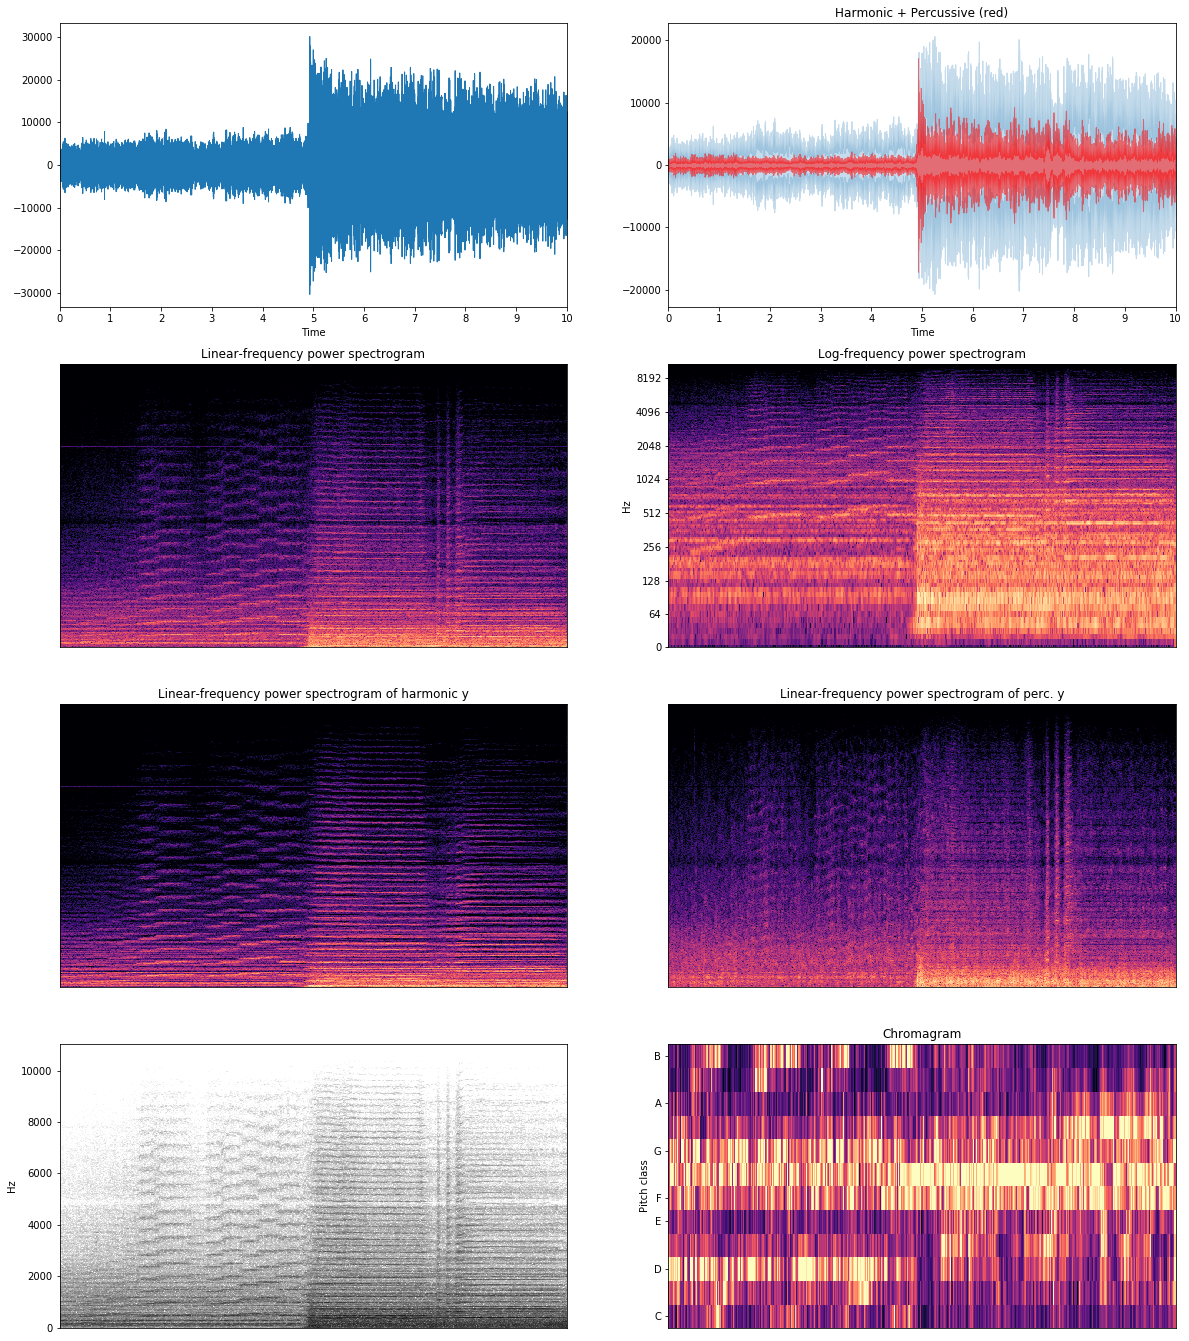

In [9]:
from __future__ import division, print_function, absolute_import
import numpy as np
import math
import os
from pydub import AudioSegment
from omapy.api import oma
import librosa
import librosa.display
import IPython.display as ipd


audio_file_path = "/home/martin/Workspace/musicData/data/recordings/BRUCKNER_Sym9-3_-_KARAJAN_BPO_[KWV_996]_1975_DG_[2530 828]/"
file_name = "03_BRUCKNER_Sym9-3_-_KARAJAN_BPO_[KWV_996]_1975_DG_[2530 828].flac"


def extract(audio_file_name, window_center, window_size):

    # wav exists? convert if not
    wav_file_name = audio_file_name + ".wav"

    if os.path.isfile(wav_file_name) == False:
        print("converting")
        sound = AudioSegment.from_file(file_name, "flac")
        sound.export(wav_file_name, format="wav")

    sound = AudioSegment.from_wav(wav_file_name)

    # going mono
    mono_sound = sound.set_channels(1)
    frame_rate = mono_sound.frame_rate
    frame_width = mono_sound.frame_width
    sound_samples = np.array(mono_sound.get_array_of_samples())
    print("frame_rate", frame_rate, "frame_width", frame_width)

    #window_center = 120.00 # 2 minutes
    #window_size = 2.00 # seconds

    window_start = window_center - ( window_size / 2 )
    window_end = window_center + ( window_size / 2 )
    print("from", window_start, "to", window_end)

    sample_index_start = window_start * frame_rate
    sample_index_end = window_end * frame_rate

    print("sample_index_start", sample_index_start, "sample_index_end", sample_index_end)

    sound_samples_window = sound_samples[int(sample_index_start):int(sample_index_end)]

    sound_samples_window = sound_samples_window.astype(np.float32, copy=False)


    plt.figure(figsize=(20, 24))

    # subplot(nrows, ncols, index, **kwargs)
    plt.subplot(4, 2, 1)
    librosa.display.waveplot(sound_samples_window, sr=frame_rate)

    plt.subplot(4, 2, 2)
    y_harm, y_perc = librosa.effects.hpss(sound_samples_window)
    librosa.display.waveplot(y_harm, sr=frame_rate, alpha=0.25)
    librosa.display.waveplot(y_perc, sr=frame_rate, color='r', alpha=0.5)
    plt.title('Harmonic + Percussive (red)')

    D = librosa.amplitude_to_db(np.abs(librosa.stft(sound_samples_window)), ref=np.max)

    plt.subplot(4, 2, 3)
    librosa.display.specshow(D)

    plt.title('Linear-frequency power spectrogram')
    #plt.colorbar(format='%+2.0f dB')

    plt.subplot(4, 2, 4)
    librosa.display.specshow(D, y_axis='log')
    #plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')


    plt.subplot(4, 2, 5)

    D_harm = librosa.amplitude_to_db(np.abs(librosa.stft(y_harm)), ref=np.max)
    librosa.display.specshow(D_harm)
    #plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram of harmonic y')


    plt.subplot(4, 2, 6)

    D_perc = librosa.amplitude_to_db(np.abs(librosa.stft(y_perc)), ref=np.max)
    librosa.display.specshow(D_perc)
    #plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram of perc. y')
    
    
    plt.subplot(4, 2, 7)
    librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
    
    
    C = librosa.feature.chroma_cqt(y=sound_samples_window, sr=frame_rate)
    plt.subplot(4, 2, 8)
    librosa.display.specshow(C, y_axis='chroma')
    # plt.colorbar()
    plt.title('Chromagram')
    
    #wavPlayer(sound_samples_window.astype(np.int16), frame_rate)
    ipd.Audio(sound_samples[int(sample_index_start):int(sample_index_end)], rate=frame_rate)

    
    
    
audio_file_path = "/home/martin/Workspace/musicData/data/recordings/BRUCKNER_Sym9-3_-_KARAJAN_BPO_[KWV_996]_1975_DG_[2530 828]/"
file_name = "03_BRUCKNER_Sym9-3_-_KARAJAN_BPO_[KWV_996]_1975_DG_[2530 828].flac"

extract(audio_file_path + file_name, 132, 10)


In [ ]:
# fetching annotations and extracting around annotations: